In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import mixture

from utilities import load_images_from_folder, crop_image, intensity_clipping, get_coordinates, get_training_data

In [2]:
images = load_images_from_folder("processed data")

Processing images: 100%|███████████████████████| 13/13 [00:00<00:00, 203.38it/s]


In [3]:
expdata = images[2]
training_data, training_coordinates = get_training_data(expdata,32)
training_coordinates[:,[1,0]] = training_coordinates[:,[0,1]]
d0, d1, d2 = training_data.shape

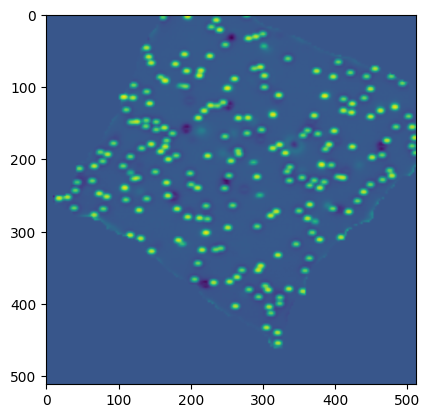

In [4]:
plt.imshow(expdata)


GMM components


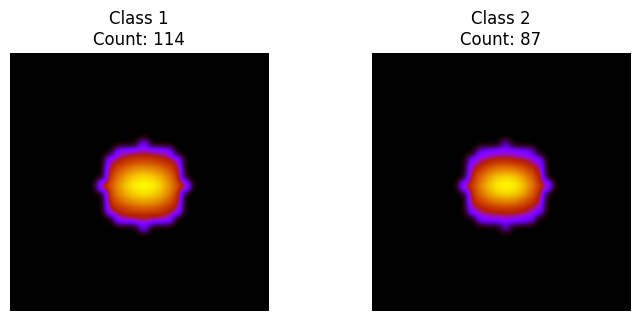

In [5]:
window_size = 32
n_components = 2
covariance = 'diag'
random_state = 1
clf = mixture.GaussianMixture(
    n_components = n_components,
    covariance_type = covariance,
    random_state = random_state)
X_vec = training_data.reshape(d0,d1*d2)
classes = clf.fit_predict(X_vec) +1
cla = np.ndarray(shape=(
    np.amax(classes), int(window_size), int(window_size)))

rows = int(np.ceil(float(n_components)/5))
cols = int(np.ceil(float(np.amax(classes))/rows))
fig = plt.figure(figsize=(4*cols, 4*(1+rows//2)))
gs = gridspec.GridSpec(rows, cols)
print('\nGMM components')

cl_all = []
for i in range(np.amax(classes)):
    cl = training_data[classes == i + 1]
    cl_all.append(cl)
    cla[i] = np.mean(cl, axis=0)
    ax = fig.add_subplot(gs[i])
    ax.imshow(cla[i, :, :], cmap='gnuplot',
            interpolation='Gaussian')
    ax.axis('off')
    ax.set_title('Class '+str(i+1)+'\nCount: '+str(len(cl)))

plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.show()

In [6]:
probs = clf.predict_proba(X_vec)
probs

array([[1.00000000e+000, 4.30970876e-070],
       [1.00000000e+000, 7.09175781e-072],
       [1.00000000e+000, 3.20418070e-073],
       [3.76551086e-074, 1.00000000e+000],
       [1.00000000e+000, 1.01646500e-088],
       [1.00000000e+000, 3.56684647e-088],
       [6.41007685e-073, 1.00000000e+000],
       [1.46734514e-085, 1.00000000e+000],
       [5.10339324e-089, 1.00000000e+000],
       [1.00000000e+000, 9.03447997e-070],
       [8.31561012e-081, 1.00000000e+000],
       [1.00000000e+000, 4.10574824e-086],
       [1.00000000e+000, 9.46904096e-085],
       [1.00000000e+000, 2.11806872e-088],
       [2.28868388e-087, 1.00000000e+000],
       [1.00000000e+000, 6.06784767e-075],
       [8.25685056e-091, 1.00000000e+000],
       [1.90177617e-083, 1.00000000e+000],
       [8.44293665e-073, 1.00000000e+000],
       [3.38037040e-082, 1.00000000e+000],
       [1.00000000e+000, 2.27361091e-098],
       [1.00000000e+000, 2.00471591e-098],
       [1.00000000e+000, 3.08415659e-097],
       [3.8

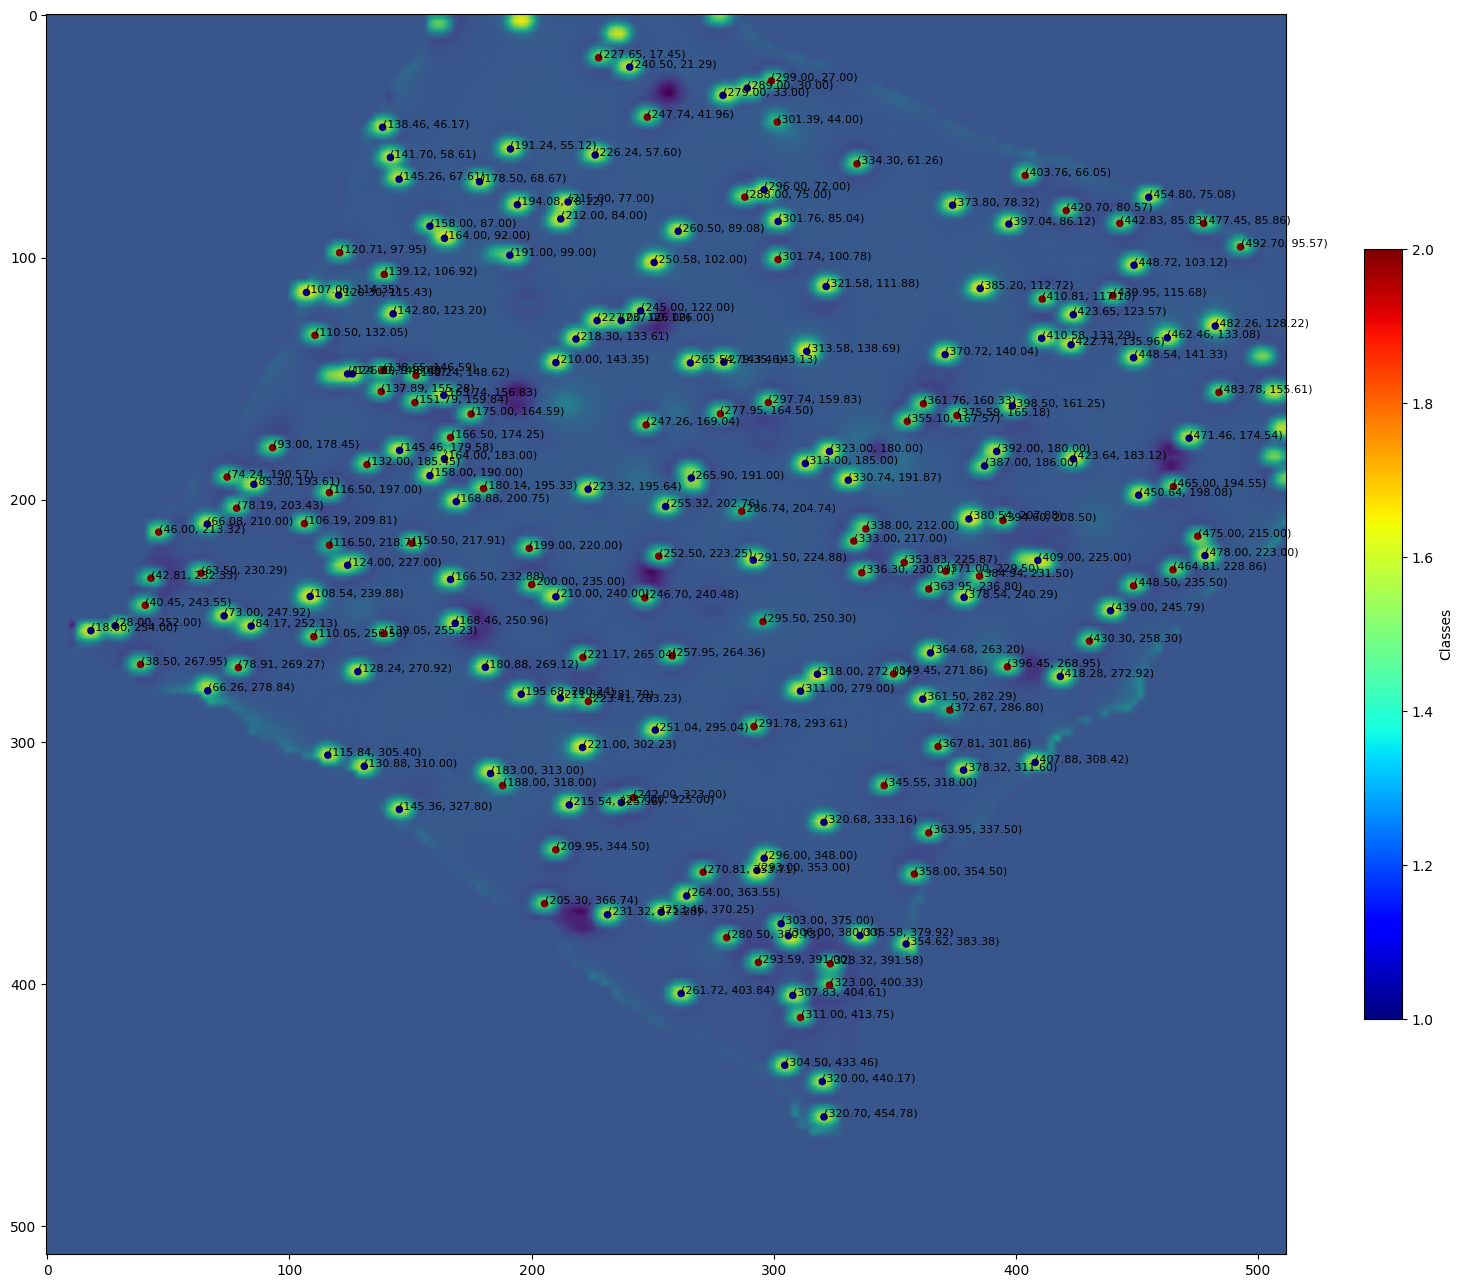

In [7]:
plt.figure(figsize=(20, 20))
sc = plt.scatter(training_coordinates[:, 0], training_coordinates[:, 1], c=classes, s=20,
            cmap="jet")
im = plt.imshow(expdata)
plt.colorbar(sc, shrink=0.5, label="Classes")
for i, coord in enumerate(training_coordinates):
    plt.text(coord[0], coord[1], f'({coord[0]:.2f}, {coord[1]:.2f})', fontsize=8, color='black')
plt.show()